<a href="https://colab.research.google.com/github/mahata-lab/Tungsten-Ductile-Brittle-Temperature/blob/main/Ductility_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Analysis

In [158]:
import pandas as pd

data = pd.read_csv('/content/RT_W_ROM.csv')
data.drop(columns = ['composition','elements'],inplace=True)

# columns that won't be used (duplicate or otherwise)
data.drop(columns = ['allen pairwise mismatch','bulk modulus R_AVG','youngs modulus R_AVG','poissons ratio R_AVG','shear modulus R_AVG'], inplace=True)

# get pugh ratio ROM
data['G/B']=data['shear modulus V_AVG']/data['bulk modulus V_AVG']

# make sure only not nans
data = data[data.loc[:,'is_ductile'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 0 to 84
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0.1                68 non-null     int64  
 1   Unnamed: 0                  68 non-null     int64  
 2   phases                      27 non-null     object 
 3   hardness (HV)               22 non-null     float64
 4   temperature (C)             68 non-null     float64
 5   compressive ys (MPa)        39 non-null     float64
 6   compressive strength (MPa)  39 non-null     float64
 7   compressive strain (%)      55 non-null     float64
 8   doi                         68 non-null     object 
 9   ys (MPa)                    12 non-null     float64
 10  uts (MPa)                   13 non-null     float64
 11  elongation (%)              13 non-null     float64
 12  pmg_comp                    68 non-null     object 
 13  is_ductile                  68 non-null   

## Dataset Analysis

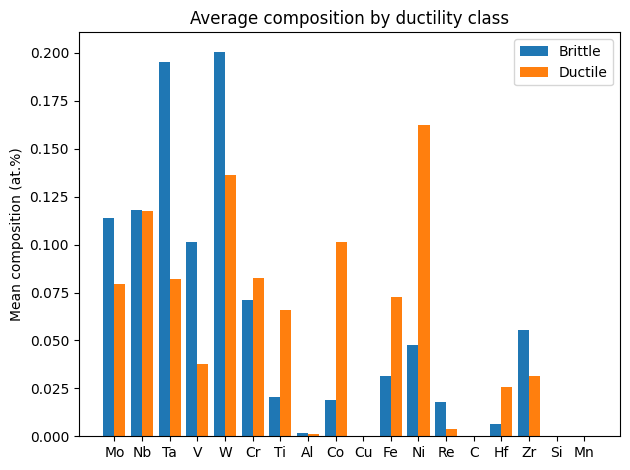

In [159]:
import matplotlib.pyplot as plt
import numpy as np

cols = data.columns[14:32]
means = data.groupby("is_ductile")[cols].mean().T  # transpose for plotting

x = np.arange(len(cols))
width = 0.4

plt.bar(x - width/2, means[False], width, label="Brittle")
plt.bar(x + width/2, means[True], width, label="Ductile")

plt.xticks(x, cols)
plt.ylabel("Mean composition (at.%)")
plt.title("Average composition by ductility class")
plt.legend()
plt.tight_layout()
plt.show()


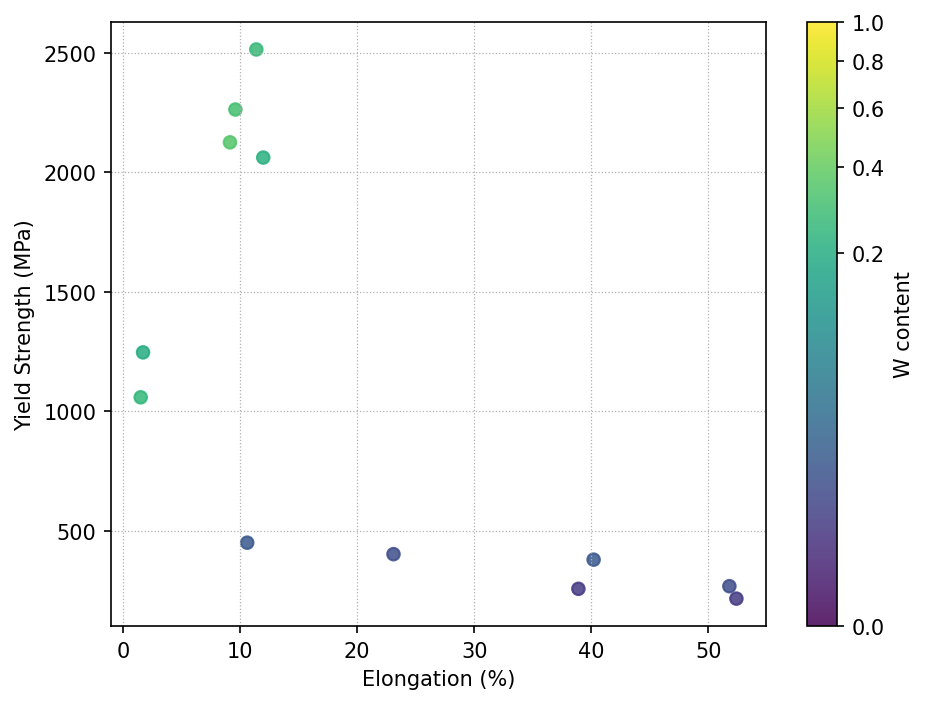

In [160]:
# DataFrame is ys_el with columns: 'ys', 'elongation', 'W'
from matplotlib.colors import PowerNorm

plt.figure(dpi=150)

norm = PowerNorm(gamma=0.3, vmin=0, vmax=max(1, data["W"].max()))  # gamma<1 => more detail near 0


sc = plt.scatter(data["elongation (%)"], data["ys (MPa)"], c=data["W"], norm=norm, s=36, alpha=0.85)
cbar = plt.colorbar(sc)
cbar.set_label("W content")

plt.xlabel("Elongation (%)")
plt.ylabel("Yield Strength (MPa)")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.tight_layout()
plt.show()

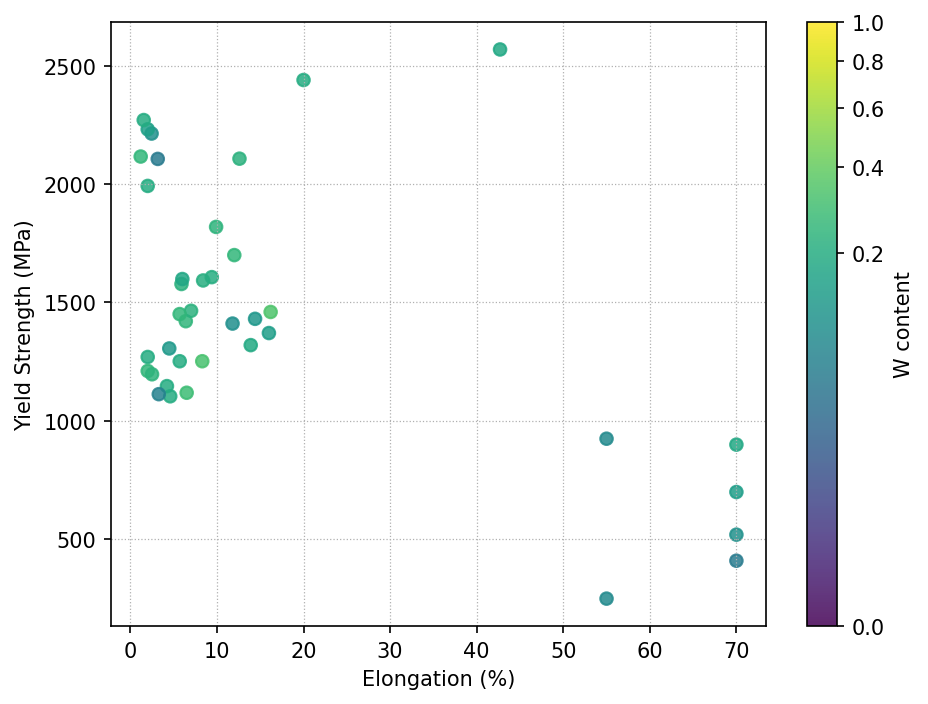

In [161]:
# DataFrame is ys_el with columns: 'ys', 'elongation', 'W'
from matplotlib.colors import PowerNorm

plt.figure(dpi=150)

norm = PowerNorm(gamma=0.3, vmin=0, vmax=max(1, data["W"].max()))  # gamma<1 => more detail near 0


sc = plt.scatter(data["compressive strain (%)"], data["compressive strength (MPa)"], c=data["W"], norm=norm, s=36, alpha=0.85)
cbar = plt.colorbar(sc)
cbar.set_label("W content")

plt.xlabel("Elongation (%)")
plt.ylabel("Yield Strength (MPa)")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.tight_layout()
plt.show()

## Creating Dataset

X = features, y = target (binary ductility class)

In [162]:
# ROM features
X = data.iloc[:,32:47]

# binary ductility classification
y = data.loc[:,'is_ductile'].astype(bool)

In [163]:
y.value_counts()

,count
is_ductile,
True,37
False,31


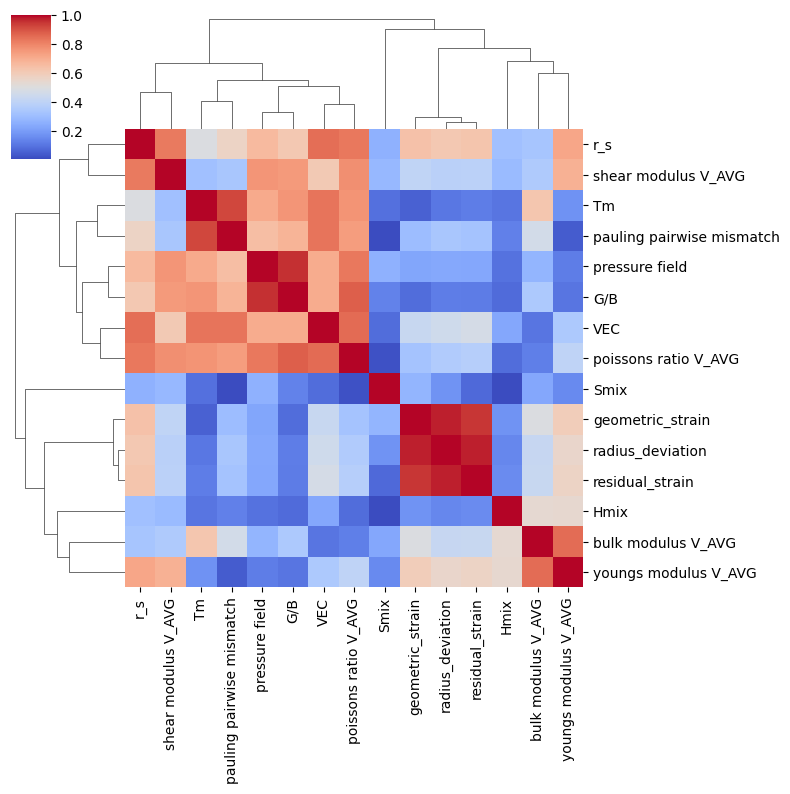

In [164]:
import seaborn as sns
corr = X.corr().abs()
sns.clustermap(corr, cmap='coolwarm', figsize=(8,8))

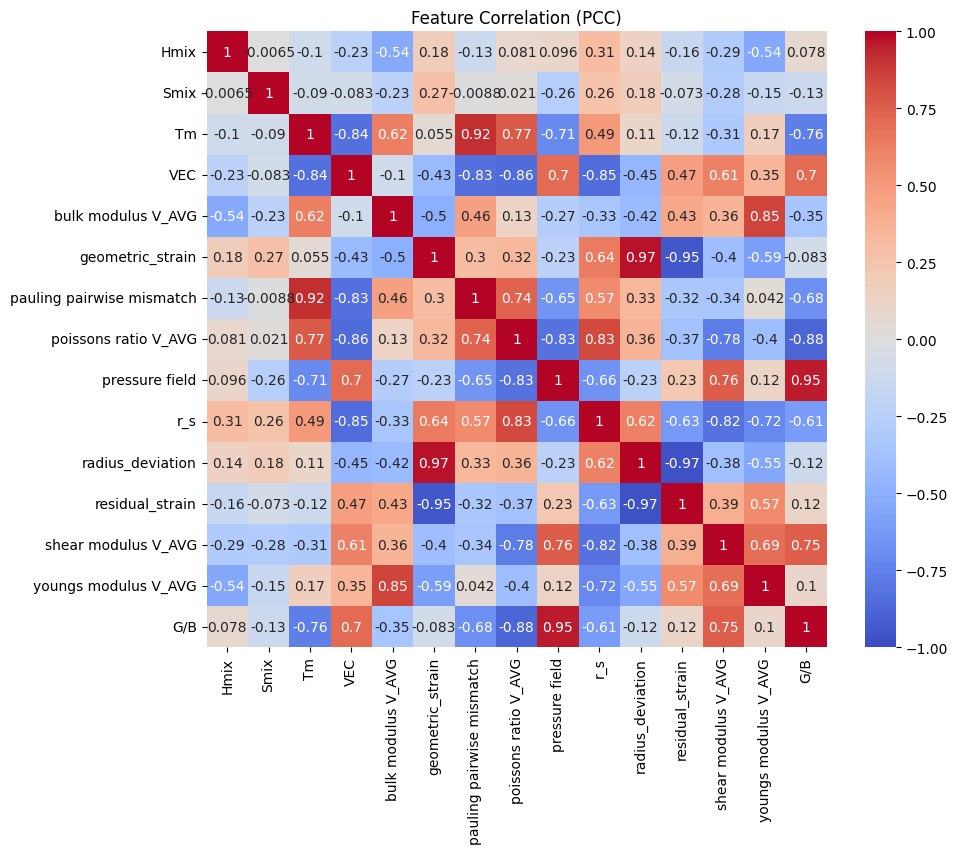

In [165]:
# look at correlation of features to reduce data size

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation (PCC)')
plt.show()

In [166]:
import numpy as np

def find_correlated_features(df, threshold=0.9):
    """
    Return a list of (feature_1, feature_2, correlation) tuples
    where |corr| > threshold.
    """
    corr = df.corr().abs()
    Ucorr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    corr_pairs = []
    for idx, row in Ucorr.iterrows():
        for col, val in row.items():
            if pd.notna(val) and val > threshold:
                corr_pairs.append((idx, col, val))

    return corr_pairs

find_correlated_features(X,threshold=0.85)


[('Tm', 'pauling pairwise mismatch', 0.9201363268162965),
 ('VEC', 'poissons ratio V_AVG', 0.8555406614971159),
 ('bulk modulus V_AVG', 'youngs modulus V_AVG', 0.8510355687993955),
 ('geometric_strain', 'radius_deviation', 0.973767225509192),
 ('geometric_strain', 'residual_strain', 0.9475917443663779),
 ('poissons ratio V_AVG', 'G/B', 0.8795841452924662),
 ('pressure field', 'G/B', 0.9541760448841315),
 ('radius_deviation', 'residual_strain', 0.9749726868227367)]

In [167]:
# choose what columns to drop based on validity of the rom calculation (interpretability and generality)
corr_col_drop = ['Tm','poissons ratio V_AVG','youngs modulus V_AVG',
                 'geometric_strain','residual_strain','poissons ratio V_AVG','pressure field']

In [168]:
# set training set to uncorrelated values
X = X.drop(columns=corr_col_drop)

# Classification Models

## Random Forest Classification

In [32]:
# Grid search of parameters for random forest

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

n_estimators = [50,100,200]
max_depth = [2,3,4,5,6, None]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [1,2,3,4,5]

rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3,
                            min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.0,
                            max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            bootstrap=True, oob_score=balanced_accuracy_score,
                            n_jobs=-1, random_state=42, ccp_alpha=0.0)

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X, y)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [78]:
# training using only one set of params

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

# random forest with default parameters --- can't do tuning with OOB due to internal bias
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3,
                            min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.0,
                            max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
                            bootstrap=True, oob_score=balanced_accuracy_score,
                            n_jobs=-1, random_state=42, ccp_alpha=0.0)

#rf.fit(X_train, y_train)
rf.fit(X, y)

y_pred = rf.predict(X)
print("test accuracy:", balanced_accuracy_score(y_pred, y))

# test the out of bag validation compared to cross-validation on training set (entire dataset)
print("OOB balanced accuracy:", rf.oob_score_)

#, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
scorers = {
    "balanced": "balanced_accuracy",
    "f1": "f1"
}

cvres = cross_validate(rf, X, y, cv=cv, scoring=scorers, return_train_score=True, n_jobs=-1)
print("CV balanced accuracy:", cvres["test_balanced"].mean())
print("CV F1:", cvres["test_f1"].mean())

test accuracy: 0.8958333333333333
OOB balanced accuracy: 0.7628596338273758
CV balanced accuracy: 0.7497619047619049
CV F1: 0.7576640232832185


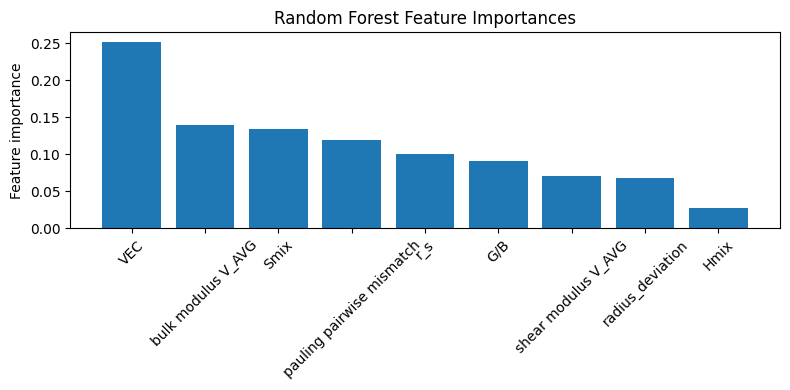

In [79]:
# impurity-based feature importance
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(X.columns)[indices], rotation=45)
plt.ylabel("Feature importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

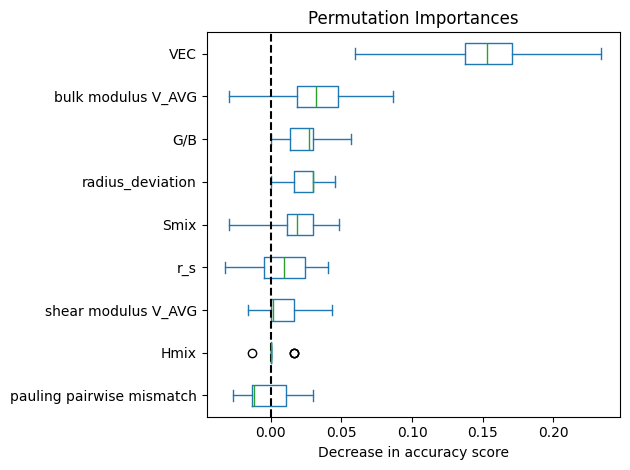

In [80]:
# permutation importance (how much the estimators rely on a feature to get correct classification)
# permutations may give a better idea of importance/weight since many of the features 'share importance'
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X, y, scoring='balanced_accuracy', n_repeats=30)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


In [45]:
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.inspection import permutation_importance

splits = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
importances = []

for train_idx, test_idx in splits.split(X):
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    r = permutation_importance(rf, X.iloc[test_idx], y.iloc[test_idx])
    importances.append(r.importances_mean)

np.std(importances, axis=0)   # feature-wise instability


array([0.0334725 , 0.04696938, 0.08142857, 0.05932873, 0.05894913,
       0.04936329, 0.02781132, 0.06027149, 0.03273268])

/tmp/ipython-input-889038126.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


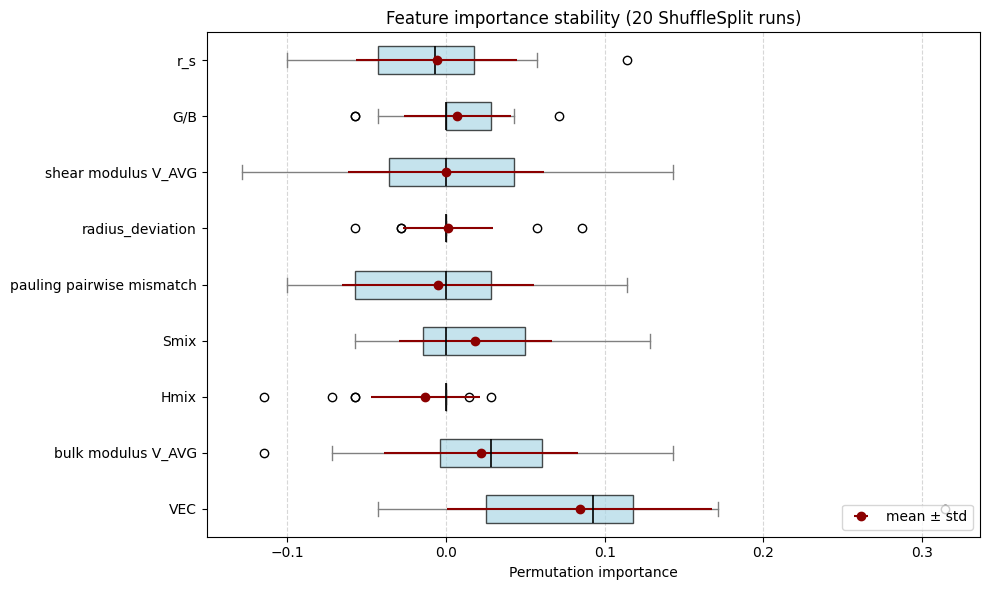

                             mean     std  median
VEC                        0.0843  0.0835  0.0929
bulk modulus V_AVG         0.0221  0.0609  0.0286
Smix                       0.0186  0.0482  0.0000
G/B                        0.0071  0.0336  0.0000
radius_deviation           0.0014  0.0285  0.0000
shear modulus V_AVG        0.0000  0.0618  0.0000
pauling pairwise mismatch -0.0050  0.0605  0.0000
r_s                       -0.0057  0.0506 -0.0071
Hmix                      -0.0129  0.0343  0.0000


In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# assuming `importances` (list of arrays) and `X.columns` exist
imp_df = pd.DataFrame(importances, columns=X.columns)
order = imp_df.median().sort_values(ascending=False).index
imp_df = imp_df[order]

# compute stats
mean_imp = imp_df.mean()
std_imp = imp_df.std()
med_imp = imp_df.median()

plt.figure(figsize=(10, 6))
plt.boxplot(
    imp_df.values,
    labels=imp_df.columns,
    vert=False,
    patch_artist=True,
    medianprops=dict(color="black", linewidth=1.2),
    boxprops=dict(facecolor="lightblue", alpha=0.7),
    whiskerprops=dict(color="gray"),
    capprops=dict(color="gray"),
)

# overlay mean points + std bars
ypos = np.arange(1, len(imp_df.columns) + 1)
plt.errorbar(mean_imp[order], ypos, xerr=std_imp[order], fmt="o", color="darkred", label="mean ± std")

plt.xlabel("Permutation importance")
plt.title("Feature importance stability (20 ShuffleSplit runs)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# numeric summary
summary = pd.DataFrame({
    "mean": mean_imp,
    "std": std_imp,
    "median": med_imp
}).sort_values("mean", ascending=False)

print(summary.round(4))


In [81]:
list(X.columns)

['Hmix',
 'Smix',
 'VEC',
 'bulk modulus V_AVG',
 'pauling pairwise mismatch',
 'r_s',
 'radius_deviation',
 'shear modulus V_AVG',
 'G/B']

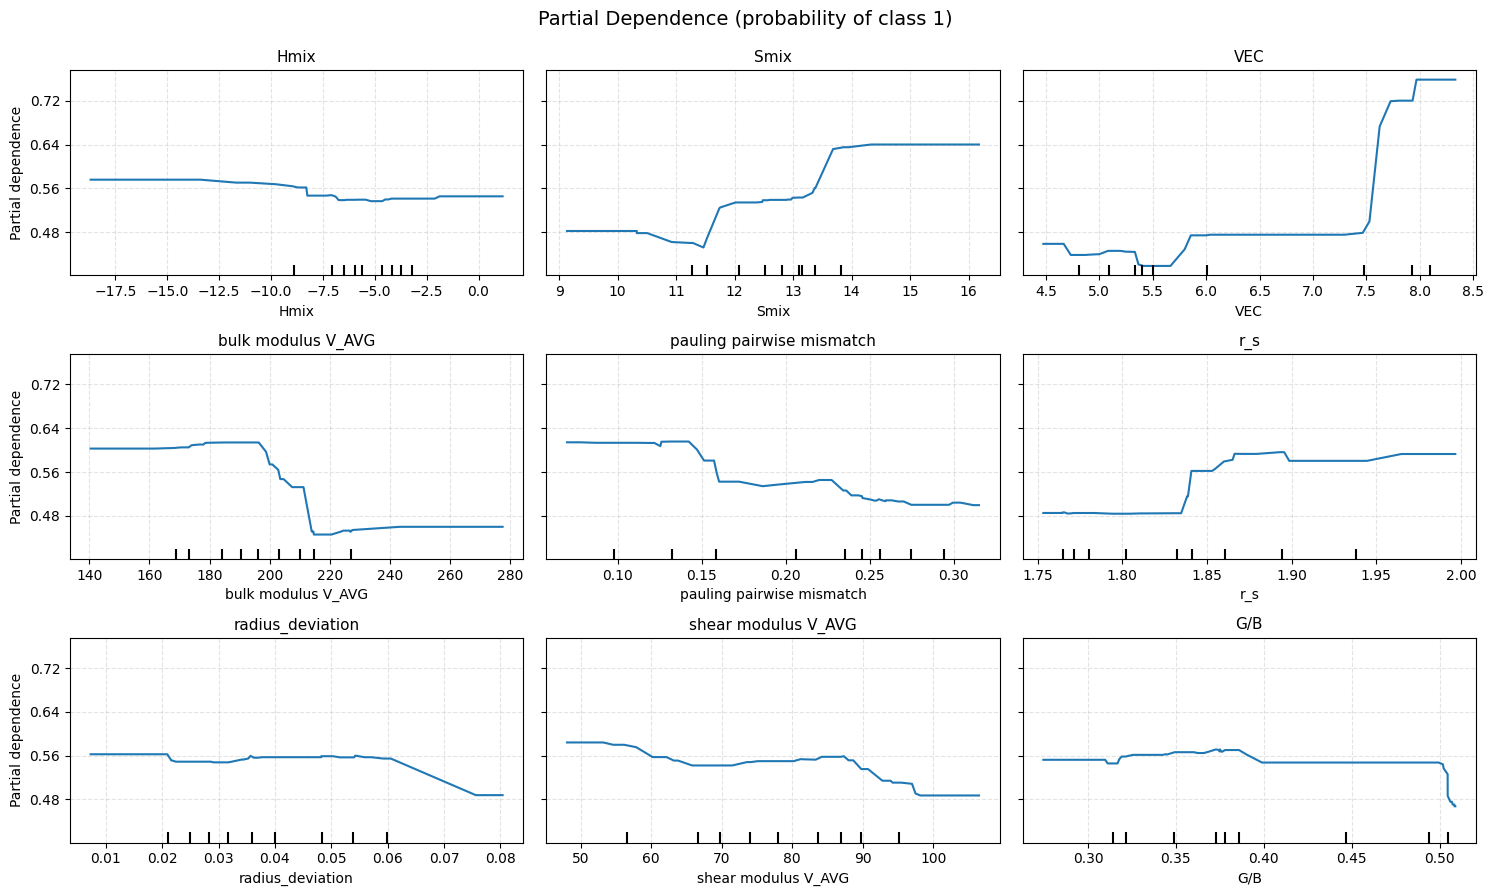

In [104]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.inspection import PartialDependenceDisplay

feats = list(X.columns)

# dynamically set number of rows and columns
ncols = 3
nrows = int(np.ceil(len(feats) / ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), sharey=True)

disp = PartialDependenceDisplay.from_estimator(
    rf, X, feats,
    ax=ax,
    kind="average",
    grid_resolution=80,
    response_method="predict_proba",
    target=1,
    percentiles=(0.05, 0.95),
)

# format subplots
axes = disp.axes_.ravel()
for i, (a, f) in enumerate(zip(axes, feats)):
    a.set_title(f, fontsize=11)
    a.grid(True, axis='both', linestyle='--', alpha=0.35)
    a.yaxis.set_major_locator(mticker.MaxNLocator(5))
    a.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    if i % ncols != 0:  # remove redundant y-labels except first column
        a.set_ylabel("")

# remove any empty axes if len(feats) not divisible by ncols
for j in range(len(feats), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Partial Dependence (probability of class 1)", y=0.99, fontsize=14)
plt.tight_layout()
plt.show()




## Logistic Regression

In [152]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# split to avoid train-eval leakage
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegressionCV(
        penalty="l1",
        solver="liblinear",
        Cs=np.logspace(-4, 4, 25),
        cv=cv,
        scoring="roc_auc",
        class_weight="balanced",   # drop if you prefer unweighted
        fit_intercept=True,
        max_iter=10000,
        tol=1e-4,
        n_jobs=-1,
        refit=True,
        random_state=0,
    ))
])

'''
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegressionCV(
        penalty="elasticnet",
        solver="saga",
        l1_ratios=[0.2, 0.5, 0.8],
        Cs=np.logspace(-4, 4, 25),
        cv=cv,
        scoring="roc_auc",
        class_weight="balanced",   # drop if you prefer unweighted
        fit_intercept=True,
        max_iter=10000,
        tol=1e-4,
        n_jobs=-1,
        refit=True,
        random_state=0,
    ))
])
'''


pipe.fit(Xtr, ytr)

# test metrics
proba = pipe.predict_proba(Xte)[:, 1]
pred  = (proba >= 0.5).astype(int)
print("ROC AUC:", roc_auc_score(yte, proba))
print("PR AUC:", average_precision_score(yte, proba))
print(classification_report(yte, pred))

# best hyperparameters chosen by CV
lr_cv = pipe.named_steps["lr"]
print("Best C per class:", lr_cv.C_)           # array shape (n_classes,) for binary → (1,)
print("Best l1_ratio:", lr_cv.l1_ratio_[0])    # scalar for binary

# coefficients in original feature order (after scaling)
coefs = lr_cv.coef_.ravel()
odds  = np.exp(coefs)
import pandas as pd
coef_df = pd.DataFrame({"feature": getattr(X, "columns", np.arange(len(coefs))),
                        "coef": coefs, "odds_ratio": odds}) \
            .sort_values("coef", ascending=False).set_index('feature')
print(coef_df)


ROC AUC: 0.6458333333333333
PR AUC: 0.7985119047619048
              precision    recall  f1-score   support

       False       0.62      0.83      0.71         6
        True       0.83      0.62      0.71         8

    accuracy                           0.71        14
   macro avg       0.73      0.73      0.71        14
weighted avg       0.74      0.71      0.71        14

Best C per class: [1.]
Best l1_ratio: None
                               coef  odds_ratio
feature                                        
r_s                        1.500636    4.484542
VEC                        1.487026    4.423917
Smix                       0.468187    1.597096
G/B                        0.000000    1.000000
bulk modulus V_AVG         0.000000    1.000000
shear modulus V_AVG       -0.217552    0.804486
radius_deviation          -0.242517    0.784651
Hmix                      -0.443062    0.642067
pauling pairwise mismatch -0.757569    0.468805


Decision boundary x = [-0.]


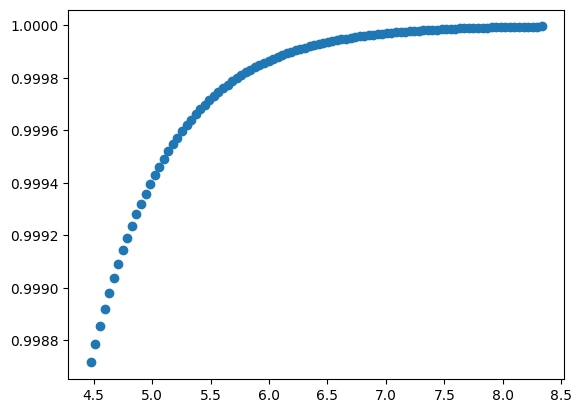

In [156]:
feat = 'VEC'
B0 = lr_cv.intercept_
B1 = coef_df.loc[feat,'coef']
x1 = np.linspace(min(X[feat]),max(X[feat]), 100)

p = 1/(1 + np.exp(-(B0 + B1 * x1)))

plt.scatter(x1,p)

print("Decision boundary x =", -B0 / B1)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names


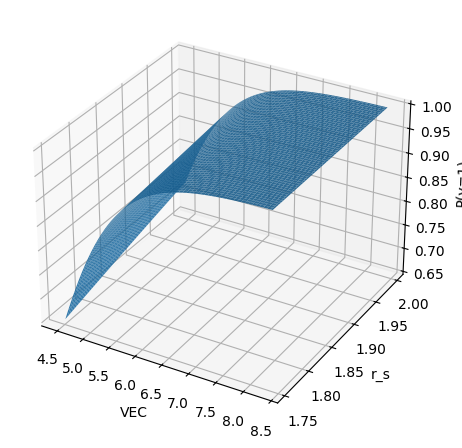

In [171]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_3d_surface(clf, X, f1, f2, target=1):
    x1 = X[f1].to_numpy(); x2 = X[f2].to_numpy()
    g1 = np.linspace(x1.min(), x1.max(), 120)
    g2 = np.linspace(x2.min(), x2.max(), 120)
    xx, yy = np.meshgrid(g1, g2)

    ref = X.median(numeric_only=True).to_dict()
    Xref = pd.DataFrame({c: ref.get(c, 0) for c in X.columns}, index=np.arange(xx.size))
    Xref[f1] = xx.ravel(); Xref[f2] = yy.ravel()

    if hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(Xref)[:, target].reshape(xx.shape)
    else:
        Z = 1/(1+np.exp(-clf.decision_function(Xref))).reshape(xx.shape)

    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, Z, rstride=2, cstride=2, alpha=0.9)
    ax.set_xlabel(f1); ax.set_ylabel(f2); ax.set_zlabel("P(y=1)")
    plt.tight_layout(); plt.show()

# usage:
plot_3d_surface(lr_cv, X, "VEC", "r_s")

## Support Vector Machine

In [ ]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [173]:
from sklearn import svm
svc = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False,
              tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr',
              break_ties=False, random_state=None)
svc.fit(Xtr, ytr)
svc.predict(Xte)
svc.score(Xte, yte)


0.5714285714285714

In [174]:
nu_svc = svm.NuSVC(nu=0.5, kernel='linear', degree=3, gamma='scale', coef0=0.0,
                   shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None,
                   verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
nu_svc.fit(Xtr, ytr)
nu_svc.predict(Xte)
nu_svc.score(Xte, yte)

0.5714285714285714

In [175]:
nu_svc = svm.NuSVC(nu=0.5, kernel='rbf', degree=3, gamma='scale', coef0=0.0,
                   shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None,
                   verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
nu_svc.fit(Xtr, ytr)
nu_svc.predict(X)
nu_svc.score(Xte, yte)

0.5714285714285714

In [176]:
lin_svc = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual='auto', tol=0.0001,
                        C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1,
                        class_weight=None, verbose=0, random_state=None, max_iter=1000)

lin_svc.fit(Xtr, ytr)
lin_svc.predict(X)
lin_svc.score(Xte, yte)

0.7142857142857143

In [177]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Always scale features before using SVMs (especially RBF kernels)
def make_svm(model):
    return Pipeline([("scaler", StandardScaler()), ("svc", model)])

# --- Base SVC (C formulation, RBF kernel) ---
svc = make_svm(
    svm.SVC(
        C=1.0,
        kernel="rbf",
        gamma="scale",
        probability=False,
        decision_function_shape="ovr",
        random_state=0,
    )
)
svc.fit(Xtr, ytr)
y_pred = svc.predict(Xte)
print("SVC (RBF) Accuracy:", svc.score(Xte, yte))
print(classification_report(yte, y_pred))

# --- NuSVC (linear kernel) ---
nu_lin = make_svm(
    svm.NuSVC(
        nu=0.5,
        kernel="linear",
        gamma="scale",
        decision_function_shape="ovr",
        random_state=0,
    )
)
nu_lin.fit(Xtr, ytr)
y_pred = nu_lin.predict(Xte)
print("NuSVC (linear) Accuracy:", nu_lin.score(Xte, yte))

# --- NuSVC (RBF kernel) ---
nu_rbf = make_svm(
    svm.NuSVC(
        nu=0.5,
        kernel="rbf",
        gamma="scale",
        decision_function_shape="ovr",
        random_state=0,
    )
)
nu_rbf.fit(Xtr, ytr)
y_pred = nu_rbf.predict(Xte)
print("NuSVC (RBF) Accuracy:", nu_rbf.score(Xte, yte))

# --- LinearSVC (fast linear solver) ---
lin_svc = make_svm(
    svm.LinearSVC(
        C=1.0,
        penalty="l2",
        loss="squared_hinge",
        dual="auto",
        fit_intercept=True,
        max_iter=5000,
        random_state=0,
    )
)
lin_svc.fit(Xtr, ytr)
y_pred = lin_svc.predict(Xte)
print("LinearSVC Accuracy:", lin_svc.score(Xte, yte))


SVC (RBF) Accuracy: 0.7142857142857143
              precision    recall  f1-score   support

       False       0.62      0.83      0.71         6
        True       0.83      0.62      0.71         8

    accuracy                           0.71        14
   macro avg       0.73      0.73      0.71        14
weighted avg       0.74      0.71      0.71        14

NuSVC (linear) Accuracy: 0.7142857142857143
NuSVC (RBF) Accuracy: 0.7142857142857143
LinearSVC Accuracy: 0.7142857142857143


In [178]:
from sklearn.model_selection import cross_val_score
for name, model in zip(["SVC", "NuLinear", "NuRBF", "Linear"],
                       [svc, nu_lin, nu_rbf, lin_svc]):
    print(name, np.mean(cross_val_score(model, X, y, cv=5)))


SVC 0.6791208791208792
NuLinear 0.6802197802197802
NuRBF 0.7065934065934066
Linear 0.6505494505494507


# Alloying strategy/visualizing decision boundary

psudo-ternary/latent space/turn forward predictions into mapping of alloy space

distribution of input elements, sample from it, generate ROM,
or distribution of ROM and calculus on input elements

decision surfaces from support vectors/logits as lagrangian constraints

## Getting distributions of new alloys from gaussian noise on existing compositions (normalize to comp sum = 1)

In [ ]:
# TEST COMMIT

In [179]:
X.columns

Index(['Hmix', 'Smix', 'VEC', 'bulk modulus V_AVG',
       'pauling pairwise mismatch', 'r_s', 'radius_deviation',
       'shear modulus V_AVG', 'G/B'],
      dtype='object')

In [186]:
comps = data.iloc[:,14:32]

In [187]:
comps

,Mo,Nb,Ta,V,W,Cr,Ti,Al,Co,Cu,Fe,Ni,Re,C,Hf,Zr,Si,Mn
0,0.20,0.20,0.200000,0.200000,0.200000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.25,0.25,0.250000,0.000000,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.00,0.239808,0.239808,0.239808,0.239808,0.040767,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.00,0.232558,0.232558,0.232558,0.232558,0.069767,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.00,0.250000,0.250000,0.250000,0.250000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.00,0.00,0.000000,0.100000,0.100000,0.200000,0.000000,0.0,0.0,0.0,0.200000,0.400000,0.0,0.0,0.0,0.0,0.0,0.0
81,0.00,0.00,0.000000,0.095238,0.142857,0.190476,0.000000,0.0,0.0,0.0,0.190476,0.380952,0.0,0.0,0.0,0.0,0.0,0.0
82,0.00,0.00,0.000000,0.133333,0.066667,0.266667,0.000000,0.0,0.0,0.0,0.266667,0.266667,0.0,0.0,0.0,0.0,0.0,0.0
83,0.00,0.00,0.000000,0.125000,0.125000,0.250000,0.000000,0.0,0.0,0.0,0.250000,0.250000,0.0,0.0,0.0,0.0,0.0,0.0


## ROM calculations on sampled alloys

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


rom = pd.read_csv('/content/total_rom_dataset.csv',index_col=0)
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)
rom.drop(['Atomic number'], axis=0, inplace=True)
rom.drop(['element'], axis=0, inplace=True)
rom = rom.astype(float)
rom.index

In [ ]:
def extract_nonzero(row):
    # only elements with nonzero composition
    mask = row != 0

    # extract elements and composition
    els = row.index[mask].to_numpy()
    x = row.values[mask].astype(float)
    return els, x

# get two new columns to use in functions
comps['elements'], comps['composition'] = zip(*comps.apply(extract_nonzero, axis=1))


### Radius mismatch
$
0.5 \;\leq\; \delta r \;\leq\; 6.5, \qquad
$

$
\delta r = \sqrt{\sum_{i=1}^n x_i \left(1 - \frac{r_i}{r}\right)^2}
$







In [ ]:
import numpy as np

def radius_deviation(x, r):
    """
    Atomic size mismatch parameter δ

    x : array of weights (compositions), should sum to 1
    r : array of atomic radii
    """
    x = np.asarray(x)
    r = np.asarray(r)

    rhat = np.dot(x, r)  # weighted mean radius

    # sum of elementwise products
    return np.sqrt(np.sum(x * (1 - r / rhat) ** 2))

els = ['Co','Fe','Ni']
x = np.array([0.333, 0.333, 0.333]).T
r = rom.loc['Atomic radius (pm)',els].values


print(radius_deviation(x,r))



0.003365508315388705


In [ ]:
# apply radius deviation function to each row of comps using lambda row to access multiple values
comps['radius_deviation'] = comps.apply(
    lambda row: radius_deviation(
        row['composition'],
        rom.loc['Atomic radius (pm)', row['elements']].to_numpy()
    ),
    axis=1
)

comps[['elements', 'composition','radius_deviation']].head()

,elements,composition,radius_deviation
0,"[Mo, Nb, Ta, V, W]","[0.2, 0.2, 0.2, 0.2, 0.2]",0.031506
1,"[Mo, Nb, Ta, W]","[0.25, 0.25, 0.25, 0.25]",0.023182
2,"[Ta, V, W, Cr, Ti]","[0.2398081534772182, 0.2398081534772182, 0.239...",0.051541
3,"[Ta, V, W, Cr, Ti]","[0.2325581395348837, 0.2325581395348837, 0.232...",0.052723
4,"[Ta, V, W, Cr]","[0.25, 0.25, 0.25, 0.25]",0.049576


### Enthalpy/Entropy of Mixing


$
\Delta H^m = \sum_{i=1}^n \sum_{\substack{j=1 \\ j \ne i}}^n 4 \Delta H_{ij}^m x_i x_j
$

is really just a [quadratic form](https://en.wikipedia.org/wiki/Quadratic_form)

$\displaystyle q_{A}(x_{1},\ldots ,x_{n})=\sum _{i=1}^{n}\sum _{j=1}^{n}a_{ij}{x_{i}}{x_{j}}=\mathbf {x} ^{\mathsf {T}}A\mathbf {x}$ when A is symmetric, which it is for pairwise mixing enthalpies. The data we have is upper triangular, so we'll transform it to a symmetric matrix with the same quadratic form.

$\displaystyle B=\left({\frac {a_{ij}+a_{ji}}{2}}\right)={\frac {1}{2}}(A+A^{\text{T}})$

so that
$\Delta H^m = \mathbf {x} ^{\mathsf {T}}B\mathbf {x}$
where x is the composition vector.

Multiplying this by 4 gives the correct Hmix according to the Miedema model


In [ ]:
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)

def alloy_Hmix(els, x, Hmix):
  '''
  input:
  els (list of element name, str)
  Hmix (df of the Hmix data)

  output:
  quadratic form Hmix matrix (np.array)
  '''
  # get the pairwise Hmix for the elements in alloy - Multiply by 4 to get 4*Hmix(i,j) in each entry of the matrix
  H = 4*np.array(Hmix.loc[els][els])

  # symmetrize
  B = 1/2*(H+H.T)

  return x.T @ B @ x

# elements in the alloy
els = ['Al','Co','Fe','Ni']
# composition vector x - will be variable in the optimization process
x = np.array([0.143, 0.286, 0.286, 0.286]).T


alloy_Hmix(els,x,Hmix)


np.float64(-9.488336)

In [ ]:
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)

comps['Hmix'] = comps.apply(
    lambda row: alloy_Hmix(
        row['elements'],
        row['composition'],
        Hmix
    ),
    axis=1
)

comps[['elements', 'composition','Hmix']].head()

,elements,composition,Hmix
0,"[Mo, Nb, Ta, V, W]","[0.2, 0.2, 0.2, 0.2, 0.2]",-4.640000
1,"[Mo, Nb, Ta, W]","[0.25, 0.25, 0.25, 0.25]",-6.500000
2,"[Ta, V, W, Cr, Ti]","[0.2398081534772182, 0.2398081534772182, 0.239...",-3.763320
3,"[Ta, V, W, Cr, Ti]","[0.2325581395348837, 0.2325581395348837, 0.232...",-3.764197
4,"[Ta, V, W, Cr]","[0.25, 0.25, 0.25, 0.25]",-3.750000


In [ ]:
# ΔSmix​= −R ∑​ci​*ln(ci)


def alloy_Smix(x):
  # only a function of the composition vector

  lnx = np.log(x)
  R = 8.314
  S = -R*(x @ lnx)
  return S

x = np.array([0.143, 0.286, 0.286, 0.286])
alloy_Smix(x)


np.float64(11.241652705037614)

In [ ]:
comps['Smix'] = comps.apply(
    lambda row: alloy_Smix(
        row['composition']
    ),
    axis=1
)

comps[['elements', 'composition','Smix']].head()

,elements,composition,Smix
0,"[Mo, Nb, Ta, V, W]","[0.2, 0.2, 0.2, 0.2, 0.2]",13.380867
1,"[Mo, Nb, Ta, W]","[0.25, 0.25, 0.25, 0.25]",11.525651
2,"[Ta, V, W, Cr, Ti]","[0.2398081534772182, 0.2398081534772182, 0.239...",12.472281
3,"[Ta, V, W, Cr, Ti]","[0.2325581395348837, 0.2325581395348837, 0.232...",12.825286
4,"[Ta, V, W, Cr]","[0.25, 0.25, 0.25, 0.25]",11.525651


### Pairwise mismatch in electronegativity

from hume rothery

$\delta_{\chi} = \frac{\sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \neq i}}^{n}
c_i c_j \left| \tfrac{\chi_i - \chi_j}{\chi} \right|}
{\sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \neq i}}^{n} c_i c_j}$

the numerator is a quadradic form since it forms a symmetric matrix by default. The denominator is just a normalization factor.


In [ ]:

def pairwise_mismatch(els,x,rom,e_type='Pauling'):

  # get the vector of electronegativity of the specified type
  chi = rom.loc[f'{electronegativity_type} electronegativity (-)', els].to_numpy()
  avg_chi = np.mean(chi)
  # cast the difference of the vectors into a matrix
  diff = abs(chi[:, None] - chi[None, :])/avg_chi

  # quadratic form to get a pairwise mismatch
  pairwise_diff = x.T @ diff @ x

  # normalization
  norm = 0
  for i in range(len(x)):
    for j in range(len(x)):
      if i != j:
        norm += x[i]*x[j]

  mismatch = pairwise_diff / norm

  return mismatch

electronegativity_type ='Pauling'
# elements in the alloy
els = ['Al', 'Co', 'Fe', 'Ni']
x = np.array([0.143, 0.286, 0.286, 0.286])

pairwise_mismatch(els,x,rom)

np.float64(0.06823420931304744)

In [ ]:
comps['pauling pairwise mismatch'] = comps.apply(
    lambda row: pairwise_mismatch(
        row['elements'],
        row['composition'],
        rom,
        e_type='Pauling'
    ),
    axis=1
)

comps[['elements', 'composition','pauling pairwise mismatch']].head()

,elements,composition,pauling pairwise mismatch
0,"[Mo, Nb, Ta, V, W]","[0.2, 0.2, 0.2, 0.2, 0.2]",0.246486
1,"[Mo, Nb, Ta, W]","[0.25, 0.25, 0.25, 0.25]",0.274716
2,"[Ta, V, W, Cr, Ti]","[0.2398081534772182, 0.2398081534772182, 0.239...",0.240477
3,"[Ta, V, W, Cr, Ti]","[0.2325581395348837, 0.2325581395348837, 0.232...",0.234225
4,"[Ta, V, W, Cr]","[0.25, 0.25, 0.25, 0.25]",0.243357


In [ ]:
comps['allen pairwise mismatch'] = comps.apply(
    lambda row: pairwise_mismatch(
        row['elements'],
        row['composition'],
        rom,
        e_type='Allen'
    ),
    axis=1
)

comps[['elements', 'composition','allen pairwise mismatch']].head()

,elements,composition,allen pairwise mismatch
0,"[Mo, Nb, Ta, V, W]","[0.2, 0.2, 0.2, 0.2, 0.2]",0.246486
1,"[Mo, Nb, Ta, W]","[0.25, 0.25, 0.25, 0.25]",0.274716
2,"[Ta, V, W, Cr, Ti]","[0.2398081534772182, 0.2398081534772182, 0.239...",0.240477
3,"[Ta, V, W, Cr, Ti]","[0.2325581395348837, 0.2325581395348837, 0.232...",0.234225
4,"[Ta, V, W, Cr]","[0.25, 0.25, 0.25, 0.25]",0.243357


In [ ]:
rom.loc[['Allen electronegativity (-)','Pauling electronegativity (-)']]

,Nb,Cd,Li,Ru,Ni,Cu,Mg,Sr,Na,W,...,Re,Os,Ca,V,Be,Ta,Zn,Cr,Rh,Ba
Allen electronegativity (-),1.41,1.52,0.91,1.54,1.88,1.85,1.29,0.96,0.87,1.47,...,1.6,1.65,1.03,1.53,1.58,1.34,1.59,1.65,1.56,0.88
Pauling electronegativity (-),1.60,1.78,0.98,2.28,1.91,1.90,1.31,0.95,0.93,2.36,...,1.9,2.20,1.00,1.63,1.57,1.50,1.65,1.66,2.20,0.89


### Voigt and Reuss averages

Voigt averages are weighted arithmetic means:

$\displaystyle V = \sum_{i=1}^n w_i P_i$


Reuss averages are weighted harmonic means:

$R = \frac{\sum_{i=1}^{n} w_i}{\sum_{i=1}^{n} \tfrac{w_i}{P_i}}$

in this case, the weights are composition, so the numerator sums to 1 every time.

The hill average is the arithmetic mean of the two bounds, and fits experimental values well for polycrystals


In [ ]:
# reuss (harmonic mean) and voigt (arithmetic mean) bounds for properties

def reuss_average(els, x, rom, prop):

  # access property vector (inverse) for the chosen property and chosen elements
  Pi = rom.loc[f'{prop}',els].apply(lambda x: 1/x).to_numpy()

  # harmonic mean with dot product of composition
  P = 1/(x @ Pi)
  return P

def voigt_average(els, x, rom, prop):

  # access property vector for the chosen property and chosen elements
  Pi = rom.loc[f'{prop}',els].to_numpy()

  # arithmetic mean with dot product of composition
  P = x @ Pi
  return P


els = ['Mo', 'Nb', 'Ta', 'W']
x = np.array([0.25, 0.25, 0.25, 0.25]).T

# using both averages gives upper and lower bounds
voigt_average(els,x,rom, 'shear modulus'), reuss_average(els,x,rom, 'shear modulus')


(np.float64(71.5), np.float64(41.0457038574286))

In [ ]:
rom.index

Index(['BCC Bulk Modulus', 'r_s', 'rho', 'Atomic radius (pm)',
       'Melting point (K)', 'Boiling point (K)',
       'Pauling electronegativity (-)', 'Allen electronegativity (-)',
       'Valence electron concentration (-)',
       'Itinerant electrons per atom (-)', 'Atomic weight (g/mol)',
       'Density (g/cm3)', 'Molar heat capacity (J/mol K)',
       'Thermal conductivity (W/m/K)', 'shear modulus', 'poissons ratio',
       'youngs modulus', 'bulk modulus'],
      dtype='object')

In [ ]:
comps['r_s'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'r_s'
    ),
    axis=1
)

In [ ]:
comps['shear modulus R_AVG'] = comps.apply(
    lambda row: reuss_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'shear modulus'
    ),
    axis=1
)

comps['shear modulus V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'shear modulus'
    ),
    axis=1
)

comps[['shear modulus R_AVG','shear modulus V_AVG']].head()


,shear modulus R_AVG,shear modulus V_AVG
0,42.112732,66.600000
1,41.045704,71.500000
2,75.856196,95.318945
3,74.231382,93.767442
4,78.264407,97.500000


In [ ]:
comps['youngs modulus R_AVG'] = comps.apply(
    lambda row: reuss_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'youngs modulus'
    ),
    axis=1
)

comps['youngs modulus V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'youngs modulus'
    ),
    axis=1
)

comps[['youngs modulus R_AVG','youngs modulus V_AVG']].head()

,youngs modulus R_AVG,youngs modulus V_AVG
0,177.397706,231.800000
1,196.340630,257.750000
2,201.725252,245.496403
3,197.316764,241.581395
4,208.266477,251.000000


In [ ]:
comps['bulk modulus R_AVG'] = comps.apply(
    lambda row: reuss_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'bulk modulus'
    ),
    axis=1
)

comps['bulk modulus V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'bulk modulus'
    ),
    axis=1
)

comps[['bulk modulus R_AVG','bulk modulus V_AVG']].head()

,bulk modulus R_AVG,bulk modulus V_AVG
0,202.380108,214.000000
1,216.731857,227.500000
2,187.236816,203.525180
3,183.344795,200.697674
4,192.996109,207.500000


In [ ]:
comps['poissons ratio R_AVG'] = comps.apply(
    lambda row: reuss_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'poissons ratio'
    ),
    axis=1
)

comps['poissons ratio V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'poissons ratio'
    ),
    axis=1
)

comps[['poissons ratio R_AVG','poissons ratio V_AVG']].head()

,poissons ratio R_AVG,poissons ratio V_AVG
0,0.334647,0.340000
1,0.326840,0.332500
2,0.287418,0.300815
3,0.288306,0.301395
4,0.286180,0.300000


In [ ]:
comps['VEC'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'Valence electron concentration (-)'
    ),
    axis=1
)
comps['VEC'].head()

,VEC
0,5.400000
1,5.500000
2,5.438849
3,5.395349
4,5.500000


In [ ]:
comps['Tm'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'Melting point (K)'
    ),
    axis=1
)
comps['Tm'].head()

,Tm
0,2962.800000
1,3157.750000
2,2800.472422
3,2774.488372
4,2837.000000


In [ ]:
comps['G/B']=comps['shear modulus V_AVG']/comps['bulk modulus V_AVG']

## Classification of sampled alloys

run through existing classifier(s)**bold text**

# Solving for Composition Directly

Use the classification models to create distributions of ROM parameters - solve for composition for samples drawn from those distributions

In [ ]:
ROM parameters =

In [ ]:
import numpy as np

def radius_deviation(x, r):
    """
    Atomic size mismatch parameter δ

    x : array of weights (compositions), should sum to 1
    r : array of atomic radii
    """
    x = np.asarray(x)
    r = np.asarray(r)

    rhat = np.dot(x, r)  # weighted mean radius

    # sum of elementwise products
    return np.sqrt(np.sum(x * (1 - r / rhat) ** 2))

In [ ]:
exp_data = pd.read_csv('/content/RT_ROM.csv')

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, LinearConstraint, Bounds, NonlinearConstraint

element_data = pd.read_csv('/content/total_rom_dataset.csv',index_col=0)
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)
element_data.drop(['Atomic number'], axis=0, inplace=True)
element_data.drop(['element'], axis=0, inplace=True)
element_data = element_data.astype(float)
element_data.index

Index(['BCC Bulk Modulus', 'r_s', 'rho', 'Atomic radius (pm)',
       'Melting point (K)', 'Boiling point (K)',
       'Pauling electronegativity (-)', 'Allen electronegativity (-)',
       'Valence electron concentration (-)',
       'Itinerant electrons per atom (-)', 'Atomic weight (g/mol)',
       'Density (g/cm3)', 'Molar heat capacity (J/mol K)',
       'Thermal conductivity (W/m/K)', 'shear modulus', 'poissons ratio',
       'youngs modulus', 'bulk modulus'],
      dtype='object')

In [ ]:
def A_matrix(properties, elements, data):
  # Construct the list of property vectors for each element
  matrix_rows = []
  for el in elements:
      element_properties = data.loc[properties, el].to_numpy()
      matrix_rows.append(element_properties)

  # Convert the list of rows to a single NumPy matrix
  A = np.array(matrix_rows)

  # return transposed matrix to get properties in columns
  return A.T

In [ ]:
'''
construction of A matrix and variables for minimize func.
properties = vector of properties to optimize from index of data
A = matrix of properties, columns are an element each
x0 = initial composition vector
lower/upper bounds
'''

properties=['r_s','Melting point (K)']

# get vectors of properties for all of the elements in an alloy
elements = ['Mo', 'Nb', 'Ta', 'W']


bnds = Bounds(0.1, 0.3)

A = A_matrix(properties, elements, element_data)
# check that the matrix has the shape (# of properties, # of elements) so that each column is an element

# set the lower and upper fraction limits of any of the elements you want (i.e.)
#lower_bounds = {'W':0.1,'Nb':0.4}
#upper_bounds = {'Mo':0.3,'Nb':0.45}

# get the number of elements being optimized on
n = A.shape[1]

# initial equiatomic alloy -- can use existing alloy and fewer steps to optimize it (LATER)
x0 = np.ones(n)/n

In [ ]:
data[elements].loc[['shear modulus','bulk modulus']]


,Mo,Nb,Ta,W
shear modulus,20.0,38.0,67.0,161.0
bulk modulus,230.0,170.0,200.0,310.0


In [ ]:
data[elements].loc['shear modulus']/data[elements].loc['bulk modulus']

,0
Mo,0.086957
Nb,0.223529
Ta,0.335000
W,0.519355


In [ ]:
'''
construction of A matrix and variables for minimize func.
properties = vector of properties to optimize from index of data
A = matrix of properties, columns are an element each
b = target vector of properties of interest - optimizes towards that
x0 = initial composition vector
composition = sum to 1
'''

properties=['r_s','Melting point (K)']
b = [1.8, 3230]

# get vectors of properties for all of the elements in an alloy
elements = ['Mo', 'Nb', 'Ta', 'W','Ti','V','Zr']

A = A_matrix(properties, elements, data)
# check that the matrix has the shape (# of properties, # of elements) so that each column is an element

# get the number of elements being optimized on
n = A.shape[1]

# initial equiatomic alloy -- can use existing alloy and fewer steps to optimize it
x0 = np.ones(n)/n


# sum of composition vector has to be 1, and each entry has to be between 0 and 1
composition_constraint = LinearConstraint(np.ones((1,n)), 1.0, 1.0)

#bnds = construct_composition_bounds(lower_bounds,upper_bounds,elements)
bnds = Bounds(0.05, 0.3)


In [ ]:
# objective function is the squared distance between current property vector (Ax) and a target (b)
# minimize objective function given the MC1 and composition constraints

obj = lambda z: np.linalg.norm(A @ z - b)**2
res = minimize(obj, x0, method="SLSQP", constraints=[composition_constraint],
               bounds = bnds,
               options={"ftol":1e-20, "maxiter":10000})
x = res.x

print(f'elements: {elements}')
print(f'composition: {x}')
print(f'total comp: {np.sum(x)}')
print(f'result: {A@x})')
print(f'target: {b}')


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_constraints.py:530: ComplexWarning: Casting complex values to real discards the imaginary part
  y[:n_bound_below] = y_all[i_bound_below] - lb[i_bound_below]
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_constraints.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  y[n_bound_below:] = -(y_all[i_bound_above] - ub[i_bound_above])


elements: ['Mo', 'Nb', 'Ta', 'W', 'Ti', 'V', 'Zr']
composition: [0.27566876 0.05       0.26536876 0.3        0.05       0.05
 0.05      ]
total comp: 1.0410375182705587
result: [1.91020599e+00 3.22999995e+03])
target: [1.8, 3230]


In [ ]:
import json

optimized = res.x
optimized = optimized*100

output = {el: val for el, val in zip(elements, optimized)}

with open('optimized.json', 'w') as f:
    json.dump(output, f)